In [2]:
# %load metamaps.py
"""Provides methods for loading/saving metamaps"""
import struct
from enum import IntEnum
from keras.utils import Sequence
import numpy as np
import os
import random
import numbers

METAMAP_FILE_VERSION = 0x100

class TileType(IntEnum):
    """Tile types in a metamap"""
    UNREACHABLE = 0
    EMPTY = 1
    WALL = 2
    PUSHWALL = 3
    DOOR = 4

class EncodingDim(IntEnum):
    """Dimensions for the one-hot encoding of a metamap"""
    PLAYABLE = 0
    SOLID = 1
    PASSAGE = 2

TileTypeToEncodingDim = {
    TileType.UNREACHABLE: EncodingDim.SOLID,
    TileType.EMPTY: EncodingDim.PLAYABLE,
    TileType.WALL: EncodingDim.SOLID,
    TileType.PUSHWALL: EncodingDim.PASSAGE,
    TileType.DOOR: EncodingDim.PASSAGE,
    }

class MetaMapsSequence(Sequence):
    """A sequence of real metamaps from a directory and randomly generated ones"""

    def __init__(self, maps_dir, batch_size):
        self.maps_dir = maps_dir
        self.batch_size = batch_size
        self.map_files = os.listdir(maps_dir)
        NUM_MAPS = len(self.map_files)
        real_maps = [(index, True) for index in range(NUM_MAPS)]
        fake_maps = [(index + NUM_MAPS, False) for index in range(NUM_MAPS)]
        map_order = real_maps + fake_maps
        np.random.shuffle(map_order)
        self.map_order = map_order

    def __len__(self):
        return int(len(self.map_order) / self.batch_size)

    def __getitem__(self, idx):
        map_batch = np.zeros((self.batch_size, 64, 64, len(EncodingDim)))
        label_batch = np.zeros((self.batch_size))

        for i in range(self.batch_size):
            (index, real_map) = self.map_order[idx * self.batch_size + i]
            if real_map:
                label_batch[i] = 1
                map_batch[i:] = load_metamap(
                    os.path.join(self.maps_dir, self.map_files[index]))
            else:
                map_batch[i:] = generate_random_map()

        return map_batch, label_batch


def generate_random_map():
    """Generate a random map"""
    width = 64
    height = 64
    size = width * height

    junk_map = np.zeros([size, len(EncodingDim)])

    for i in range(size):
        tile_type = random.randint(0, len(EncodingDim) - 1)
        junk_map[i, tile_type] = 1

    junk_map.shape = (width, height, len(EncodingDim))

    return junk_map


def load_all_metamaps(dirname, number_cap=None):
    """Loads all the metamaps in the given directory, returning a giant numpy array"""
    map_names = os.listdir(dirname)
    if isinstance(number_cap, numbers.Integral) and number_cap > 0:
        map_names = map_names[:number_cap]
    all_maps = np.zeros((len(map_names), 64, 64, len(EncodingDim)))

    for index, map_name in enumerate(map_names):
        load_metamap_into(os.path.join(dirname, map_name), all_maps, index)

    return all_maps


def load_metamap_into(filename, all_maps, index):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]

        raw_map = np.fromfile(fin, dtype=np.uint8)
        raw_map.shape = (width, height)

        for y in range(height):
            for x in range(width):
                tile_type = TileType(raw_map[y, x])
                all_maps[index, y, x, TileTypeToEncodingDim[tile_type]] = 1


def load_metamap(filename):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]
        size = width * height

        raw_map = np.fromfile(fin, dtype=np.uint8)
        one_hot = np.zeros([size, len(EncodingDim)])

        for i in range(size):
            tile_type = TileType(raw_map[i])
            one_hot[i, TileTypeToEncodingDim[tile_type]] = 1

        one_hot.shape = (width, height, len(EncodingDim))

        return one_hot


def save_metamap(metamap, filename):
    """Saves a metamap to a file"""
    with open(filename, "wb") as fout:
        fout.write(struct.pack('Q', METAMAP_FILE_VERSION))

        width = metamap.shape[0]
        height = metamap.shape[1]

        fout.write(struct.pack('i', width))
        fout.write(struct.pack('i', height))
        for y in range(height):
            for x in range(width):
                tile_type = TileType.WALL
                if metamap[y, x, EncodingDim.PLAYABLE] == 1:
                    tile_type = TileType.EMPTY
                elif metamap[y, x, EncodingDim.SOLID] == 1:
                    tile_type = TileType.WALL
                elif metamap[y, x, EncodingDim.PASSAGE] == 1:
                    tile_type = TileType.DOOR

                fout.write(struct.pack('b', tile_type))
    return

C:\Users\david\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [33]:
with open("MegaMetaMap", "rb") as fin:
    mega_meta_map = np.fromfile(fin, dtype=np.uint8)

In [34]:
mega_meta_map.shape

(420950016,)

In [35]:
mega_meta_map.shape = (int(mega_meta_map.shape[0]/64/3), 64, 3)

In [36]:
mega_meta_map.shape

(2192448, 64, 3)

In [38]:
int(mega_meta_map.shape[0]/64)

34257

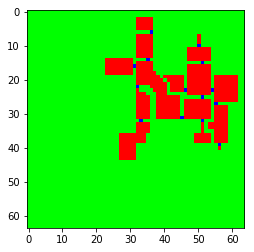

In [39]:
import matplotlib.pyplot as plt

plt.imshow(mega_meta_map[:64,:,:].astype('float32'))
plt.show()

In [13]:
figure[0,0,1]

1.0

In [15]:
mm = load_metamap('metamaps_user\\10levels 01 - Wolf1 Map1 m.metamap')

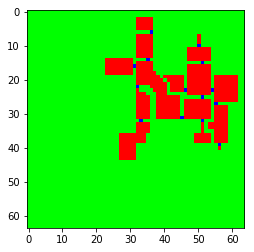

In [16]:
plt.imshow(mm)
plt.show()